# Yamamoto et al. (1990) :  Axial-Rotation and Bending

- Performed by: Yash Niranjan Poojary
- Reviewed by:
- Last modified : 28th december 2023
- SAFER HBM Version: ![Static Badge](https://img.shields.io/badge/SAFER_HBM-11.0-1?style=flat&logoColor=blue&labelColor=whitw&color=blue)
- LSDYNA version:  `mpp d R12.2.1 `

## Experiment by yamamoto et al. (1990)

The simulated outputs are compared to the references from PMHS tests reported by Yamamoto et al.  <sup>[1]</sup>
1.	Yamamoto I, Panjabi MM, Crisco T, Oxland T. Three-dimensional movements of the whole lumbar spine and lumbosacral joint. Spine. 1989;14(11):1256-60.

<!-- ![](../_env/setup_yamamoto_V11.png) -->
```{figure} ../_env/setup_yamamoto_V11.png
---
align: center
---
Setup for L1- Sacrum-pelvis
```
## Summary of the experiment

- `Coordinate system `    : aligned with Global in simulations
- `Load case`    :  Axial rotation, flexion, extension and lateral bending for the complete lumbar spine.
- 10 fresh lumbar spines from PMHSs aged between 25 and 63 years, but of unknown sex, stature and weight.

### Loading and Boundary Conditions
- The specimens were loaded in six pure moment cases, flexion, extension, left-right axial rotation and left-right lateral bending.
- At the superior end L1 vertebrae were constrained in epoxy.
- At the inferior end, the sacral vertebrae and pelvis were constrained in epoxy which is rigidly attached to the test table.
- The potting constrain was implimented in LS-DYNA using  `*CONSTRAINT_SHELL_IN_SOLID_PENALTY`. 
- Pure moment loads in steps of 2.5 Nm up to 10 Nm, were applied to the superior potting in the test. This was implimented by applying a very low rotation displacement to the superior potting using `*BOUNDARY_PRESCRIBED_MOTION_RIGID`.
- To achieve pure moments the superior potting was free in all DOFs.

#### Assumptions
- Based on the figures in the litrature [1] it was estimated that the spine was in a neutral (or lordotic) position.
- So, the “LUMB_FLEX” parameter in the SHBM lumbar spine was set to `-1`

#### Modelling in dyna
##### submodel preparation
- Vertebrae level from L1 to Pelvis is extracted from the model.
- The bony, ligamentous and cartilaginous structures of the specimens were retained for testing.
- **Illio lumbar ligaments were removed**
- All the muscles elements are removed. 

##### Potting
- Both ends of each specimen were potted with using epoxy block.
- This was modeeled using `MAT_ELASTIC` potting material with $E=2Gpa$ and the based modelled with `MAT_RIGID` to prescribe the loads and constraints.
- The potting did not impede the motion at the discs of the corresponding potted levels.
- The superior surface of L4 was maintained horizontal while potting.

### Responses recorded
- The rotational displacement at each vertebral level is recorded.
- Reaction moments in the upper potting was recorded.
- The reference values from the paper were digitalised [2]  and are incuded in the notebook. The data corresponds to the unnormalised corridors.

### Other references
2.	Drevon D, Fursa SR, Malcolm AL. Intercoder reliability and validity of WebPlotDigitizer in extracting graphed data. Behavior modification. 2017;41(2):323-39. 
3.	Iraeus J, Poojary YN, Jaber L, John J, Davidsson J.[ A new open-source finite element lumbar spine model, its tuning and validation, and development of a tissue-based injury risk function for compression fractures](http://www.ircobi.org/wordpress/downloads/irc23/pdf-files/23132.pdf). Nucleus. 2023;3:4.


In [1]:
import os
import glob
# for data analysis
import pandas as pd
import numpy as np
import math as mt
# packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Plot formats
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1)
s11 = {"linestyle" :'-', "color" : 'b',"alpha" :1,"linewidth":2}
pmhs = {"linestyle" :'--', "color" : 'k',"alpha" :0.7,"linewidth":1}
pmhs_marked = {"linestyle" :'--', "color" : 'k',"alpha" :1,"linewidth":1, 'marker' :"o", 'markevery': 1}
pmhsM = {"linestyle" :'--', "color" : 'b',"alpha" :0.7,"linewidth":1}
pmhsF = {"linestyle" :'--', "color" : 'r',"alpha" : 0.7,"linewidth":1}
Test_avg = {"linestyle" :'-', "color" : 'k',"alpha" :1,"linewidth":1, 'marker' :"o", 'markevery': 75}
test_corr = {"color": 'silver',"alpha" : 0.7,'linewidth':0.0}
Test_avg_norm = {"linestyle" :'-', "color" : 'k',"alpha" :1,"linewidth":1, 'marker' :"o", 'markevery': 75,'mfc': 'seagreen','mec': 'seagreen'}

# Dataframe formats
def select_col(x):
    mask = x['Overall Score'] <0.5
    df1 =  pd.DataFrame('', index=x.index, columns=x.columns)
    df1.loc[mask,'Overall Score'] = 'color:crimson;font-weight:bold;'
    return df1
heading = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("font-weight", "bold")])]
content={'text-align': 'center'}

In [29]:
# Tests=['flexion']
Tests=['flexion','extension','lateral_bending','axial_rotation']
figures_dir = "../data/processed/SAFER11.0/figures/"
processed_data_dir = f"../data/processed/SAFER11.0"
experiment_dir= "../data/experiment_data/"
binout_path_sim={}
result_output_dir={}

if not os.path.exists(processed_data_dir): 
    os.makedirs(processed_data_dir)
if not os.path.exists(figures_dir): 
    os.makedirs(figures_dir)

for test in Tests:
    binout_path_sim[test] = test
    result_output_dir[test] = os.path.join(processed_data_dir, binout_path_sim[test])
    if not os.path.exists(result_output_dir[test]): 
        os.makedirs(result_output_dir[test])

## Postprocessing with dynasaur

In [30]:
# Import the dynasaur library
from dynasaur.plugins.data_visualization_controller import DataVisualizationController

In [31]:
# Path to Dynasaur definition files

# Dynasaur object definitions
dynasaur_ids = ["../_env/post_ID_V11.def"]

# Dynasaur calculation definitions
dynasaur_calculation_defs = [ "../_env/post_calculation.def","../../model/SAFER_11.0/postprocessing/01_energy_calculation.def"]

In [32]:
sim_output={}
exp={}
for test in Tests:
    sim = DataVisualizationController(calculation_procedure_def_file=dynasaur_calculation_defs,
                                                  object_def_file=dynasaur_ids,
                                                  data_source= binout_path_sim[test] +'/binout*')
    commands = sim.get_defined_calculation_procedures()
    print(commands)
    for command in sim.get_defined_calculation_procedures():
        sim.calculate(command)
    # export post-processed data
    sim.write_CSV(result_output_dir[test], filename="Dynasaur_output.csv")
    # Import processed data
    sim_output[test]=pd.read_csv(os.path.join(result_output_dir[test],"Dynasaur_output.csv"), delimiter=';', na_values='-', header = [0,1,2,3])

[READ DYNASAUR DEF]	read ../_env/post_calculation.def
[READ DYNASAUR DEF]	read ../../model/SAFER_11.0/postprocessing/01_energy_calculation.def
[READ DYNASAUR DEF]	done
[READ DYNASAUR DEF]	read ../_env/post_ID_V11.def
[READ DYNASAUR DEF]	done
[READ BINOUT]	read nodout data ...
[READ BINOUT]	done reading nodout!
[READ BINOUT]	read bndout data ...
[READ BINOUT]	done reading bndout!
[READ BINOUT]	read rbdout data ...
[READ BINOUT]	done reading rbdout!
[READ BINOUT]	read glstat data ...
[READ BINOUT]	done reading glstat!
[{'visualization': 'Spine_L1x', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Spine_L1y', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Spine_L1z', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Spine_L2x', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Spine_L2y', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Spine_L2z', 'x_label': 'time', 'y_label': 'angle'}, {'visualization': 'Spine_L3x', 'x_label': 'time', '

In [34]:
# Import experimental data
exp_L12=pd.read_csv(os.path.join(experiment_dir,'L12.csv'),delimiter=';',header=[0])
exp_L23=pd.read_csv(os.path.join(experiment_dir,'L23.csv'),delimiter=';',header=[0])
exp_L34=pd.read_csv(os.path.join(experiment_dir,'L34.csv'),delimiter=';',header=[0])
exp_L45=pd.read_csv(os.path.join(experiment_dir,'L45.csv'),delimiter=';',header=[0])
exp_L5S1=pd.read_csv(os.path.join(experiment_dir,'L5S1.csv'),delimiter=';',header=[0])

## Response Plots
### Full spine response

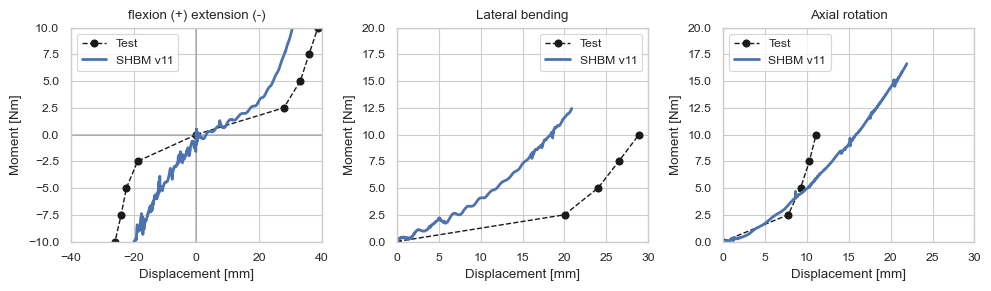

In [61]:
fig_L12, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 3))
# --------------------------------------------------------------F-E--------------------------------------------------------------
ax[0].plot(exp_L12.Fx+exp_L23.Fx+exp_L34.Fx+exp_L45.Fx+exp_L5S1.Fx,exp_L12.Fy,**pmhs_marked,label='Test')
ax[0].plot(exp_L12.Ex+exp_L23.Ex+exp_L34.Ex+exp_L45.Ex+exp_L5S1.Ex,-exp_L12.Ey,**pmhs_marked)
ax[0].set(xlim=[-40,40],ylim=[-10,10],xlabel='Displacement [mm]',title='flexion (+) extension (-)',ylabel='Moment [Nm]');
ax[0].axhline(y=0, color='gray',alpha=0.5)
ax[0].axvline(x=0, color='gray',alpha=0.5)
ax[0].plot(np.degrees(pd.DataFrame(sim_output['flexion'].loadcell.RotationY.Rotation)),
           pd.DataFrame(sim_output['flexion'].loadcell.Momenty.moment)+0.5,**s11,label='SHBM v11')
ax[0].plot(np.degrees(pd.DataFrame(sim_output['extension'].loadcell.RotationY.Rotation.iloc[0:600])),
           pd.DataFrame(sim_output['extension'].loadcell.Momenty.moment.iloc[0:600])+0.5,**s11)

# # --------------------------------------------------------------Lateral bending--------------------------------------------------------------

ax[1].plot(exp_L12.Lbx+exp_L23.Lbx+exp_L34.Lbx+exp_L45.Lbx+exp_L5S1.Lbx,exp_L12.Lby,**pmhs_marked,label='Test')
ax[1].set(xlim=[0,30],ylim=[0,20],xlabel='Displacement [mm]',title='Lateral bending',ylabel='Moment [Nm]');
ax[1].plot(-np.degrees(pd.DataFrame(sim_output['lateral_bending'].loadcell.RotationX.Rotation.iloc[0:700])),
           -pd.DataFrame(sim_output['lateral_bending'].loadcell.Momentx.moment.iloc[0:700]),**s11,label='SHBM v11')


# # --------------------------------------------------------------Axial Rotation--------------------------------------------------------------

ax[2].plot(exp_L12.Arx+exp_L23.Arx+exp_L34.Arx+exp_L45.Arx+exp_L5S1.Arx,exp_L12.Ary,**pmhs_marked,label='Test')
ax[2].set(xlim=[0,30],ylim=[0,20],xlabel='Displacement [mm]',title='Axial rotation',ylabel='Moment [Nm]');
ax[2].plot(-np.degrees(pd.DataFrame(sim_output['axial_rotation'].loadcell.RotationZ.Rotation))
           ,-pd.DataFrame(sim_output['axial_rotation'].loadcell.Momentz.moment),**s11,label='SHBM v11')

for l in range (3):
    ax[l].legend()
fig_L12.tight_layout()

#### Functional spine units response
##### L1-L2

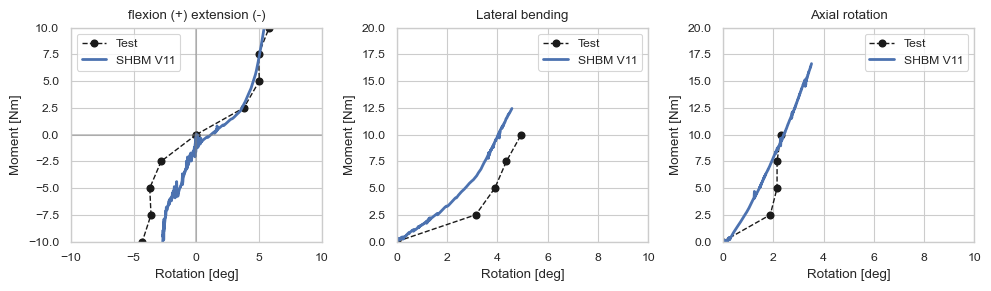

In [62]:
fig_FSU, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 3))

ax[0].plot(exp_L12.Fx,exp_L12.Fy,**pmhs_marked,label='Test')
ax[0].plot(exp_L12.Ex,-exp_L12.Ey,**pmhs_marked)
ax[0].plot(np.degrees(pd.DataFrame(sim_output['flexion'].Spine.L1y.angle-sim_output['flexion'].Spine.L2y.angle)),
           pd.DataFrame(sim_output['flexion'].loadcell.Momenty.moment),**s11,label='SHBM V11')
ax[0].plot(np.degrees(pd.DataFrame(sim_output['extension'].Spine.L1y.angle.iloc[0:600]-sim_output['extension'].Spine.L2y.angle.iloc[0:600])),
           pd.DataFrame(sim_output['extension'].loadcell.Momenty.moment.iloc[0:600]),**s11)
ax[0].set(xlim=[-10,10],ylim=[-10,10],xlabel='Rotation [deg]',title='flexion (+) extension (-)',ylabel='Moment [Nm]');
ax[0].axhline(y=0, color='gray',alpha=0.5)
ax[0].axvline(x=0, color='gray',alpha=0.5)

ax[1].plot(exp_L12.Lbx,exp_L12.Lby,**pmhs_marked,label='Test')
ax[1].plot(-np.degrees(pd.DataFrame(sim_output['lateral_bending'].Spine.L1x.angle.iloc[0:700]-sim_output['lateral_bending'].Spine.L2x.angle.iloc[0:700])),
           -pd.DataFrame(sim_output['lateral_bending'].loadcell.Momentx.moment.iloc[0:700]),**s11,label='SHBM V11')
ax[1].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Lateral bending',ylabel='Moment [Nm]');

ax[2].plot(exp_L12.Arx,exp_L12.Ary,**pmhs_marked,label='Test')
ax[2].plot(-np.degrees(pd.DataFrame(sim_output['axial_rotation'].Spine.L1z.angle-sim_output['axial_rotation'].Spine.L2z.angle)),
           -pd.DataFrame(sim_output['axial_rotation'].loadcell.Momentz.moment),**s11,label='SHBM V11')
ax[2].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Axial rotation',ylabel='Moment [Nm]');

for l in range (3):
    ax[l].legend()
fig_FSU.tight_layout()

##### L2-L3

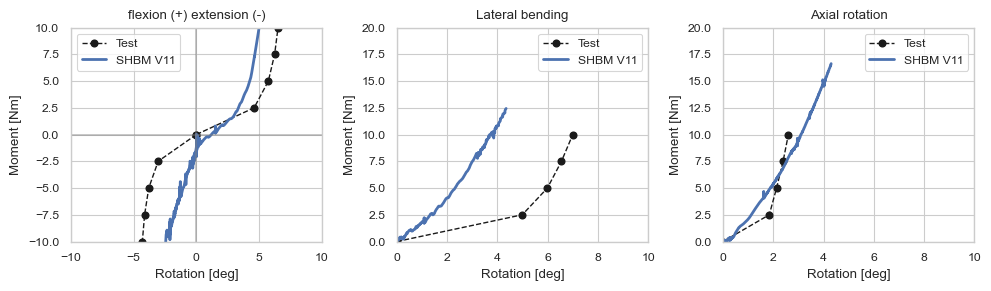

In [63]:
fig_FSU, ax = plt.subplots(nrows=1, ncols=3,figsize=(10,3))

ax[0].plot(exp_L23.Fx,exp_L23.Fy,**pmhs_marked,label='Test')
ax[0].plot(exp_L23.Ex,-exp_L23.Ey,**pmhs_marked)
ax[0].plot(np.degrees(pd.DataFrame(sim_output['flexion'].Spine.L2y.angle-sim_output['flexion'].Spine.L3y.angle)),
           pd.DataFrame(sim_output['flexion'].loadcell.Momenty.moment),**s11,label='SHBM V11')
ax[0].plot(np.degrees(pd.DataFrame(sim_output['extension'].Spine.L2y.angle.iloc[0:600]
                                   -sim_output['extension'].Spine.L3y.angle.iloc[0:600])),
           pd.DataFrame(sim_output['extension'].loadcell.Momenty.moment.iloc[0:600]),**s11)
ax[0].set(xlim=[-10,10],ylim=[-10,10],xlabel='Rotation [deg]',title='flexion (+) extension (-)',ylabel='Moment [Nm]');
ax[0].axhline(y=0, color='gray',alpha=0.5)
ax[0].axvline(x=0, color='gray',alpha=0.5)

ax[1].plot(exp_L23.Lbx,exp_L23.Lby,**pmhs_marked,label='Test')
ax[1].plot(-np.degrees(pd.DataFrame(sim_output['lateral_bending'].Spine.L2x.angle.iloc[0:700]
                                    -sim_output['lateral_bending'].Spine.L3x.angle.iloc[0:700])),
           -pd.DataFrame(sim_output['lateral_bending'].loadcell.Momentx.moment.iloc[0:700]),**s11,label='SHBM V11')
ax[1].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Lateral bending',ylabel='Moment [Nm]');

ax[2].plot(exp_L23.Arx,exp_L23.Ary,**pmhs_marked,label='Test')
ax[2].plot(-np.degrees(pd.DataFrame(sim_output['axial_rotation'].Spine.L2z.angle
                                    -sim_output['axial_rotation'].Spine.L3z.angle)),
           -pd.DataFrame(sim_output['axial_rotation'].loadcell.Momentz.moment),**s11,label='SHBM V11')
ax[2].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Axial rotation',ylabel='Moment [Nm]');
for l in range (3):
    ax[l].legend()
fig_FSU.tight_layout()

##### L3-L4

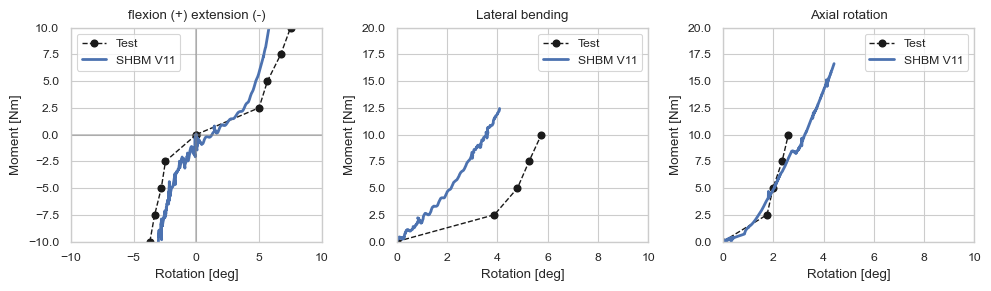

In [64]:
fig_FSU, ax = plt.subplots(nrows=1, ncols=3,figsize=(10,3))

ax[0].plot(exp_L34.Fx,exp_L34.Fy,**pmhs_marked,label='Test')
ax[0].plot(exp_L34.Ex,-exp_L34.Ey,**pmhs_marked)
ax[0].plot(np.degrees(pd.DataFrame(sim_output['flexion'].Spine.L3y.angle
                                   -sim_output['flexion'].Spine.L4y.angle)),
           pd.DataFrame(sim_output['flexion'].loadcell.Momenty.moment),**s11,label='SHBM V11')
ax[0].plot(np.degrees(pd.DataFrame(sim_output['extension'].Spine.L3y.angle.iloc[0:600]
                                   -sim_output['extension'].Spine.L4y.angle.iloc[0:600])),
           pd.DataFrame(sim_output['extension'].loadcell.Momenty.moment.iloc[0:600]),**s11)
ax[0].set(xlim=[-10,10],ylim=[-10,10],xlabel='Rotation [deg]',title='flexion (+) extension (-)',ylabel='Moment [Nm]');
ax[0].axhline(y=0, color='gray',alpha=0.5)
ax[0].axvline(x=0, color='gray',alpha=0.5)

ax[1].plot(exp_L34.Lbx,exp_L34.Lby,**pmhs_marked,label='Test')
ax[1].plot(-np.degrees(pd.DataFrame(sim_output['lateral_bending'].Spine.L3x.angle.iloc[0:700]
                                    -sim_output['lateral_bending'].Spine.L4x.angle.iloc[0:700])),
           -pd.DataFrame(sim_output['lateral_bending'].loadcell.Momentx.moment.iloc[0:700]),**s11,label='SHBM V11')
ax[1].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Lateral bending',ylabel='Moment [Nm]');

ax[2].plot(exp_L34.Arx,exp_L34.Ary,**pmhs_marked,label='Test')
ax[2].plot(-np.degrees(pd.DataFrame(sim_output['axial_rotation'].Spine.L3z.angle
                                    -sim_output['axial_rotation'].Spine.L4z.angle)),
           -pd.DataFrame(sim_output['axial_rotation'].loadcell.Momentz.moment),**s11,label='SHBM V11')
ax[2].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Axial rotation',ylabel='Moment [Nm]');

for l in range (3):
    ax[l].legend()
fig_FSU.tight_layout()

##### L4-L5

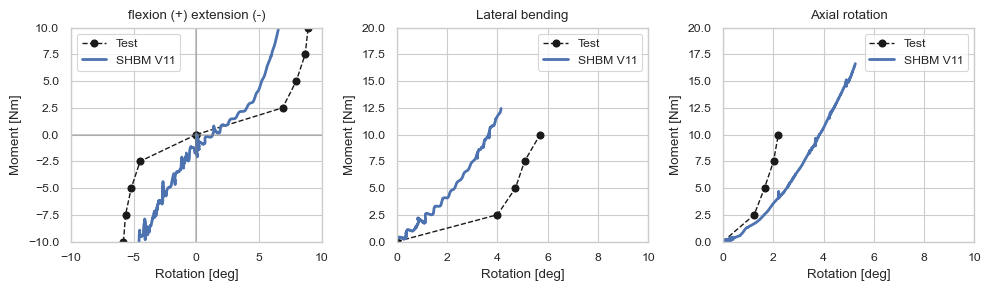

In [65]:
fig_FSU, ax = plt.subplots(nrows=1, ncols=3,figsize=(10,3))

ax[0].plot(exp_L45.Fx,exp_L45.Fy,**pmhs_marked,label='Test')
ax[0].plot(exp_L45.Ex,-exp_L45.Ey,**pmhs_marked)
ax[0].plot(np.degrees(pd.DataFrame(sim_output['flexion'].Spine.L4y.angle-sim_output['flexion'].Spine.L5y.angle)),
           pd.DataFrame(sim_output['flexion'].loadcell.Momenty.moment),**s11,label='SHBM V11')
ax[0].plot(np.degrees(pd.DataFrame(sim_output['extension'].Spine.L4y.angle.iloc[0:600]
                                   -sim_output['extension'].Spine.L5y.angle.iloc[0:600])),
           pd.DataFrame(sim_output['extension'].loadcell.Momenty.moment.iloc[0:600]),**s11)
ax[0].set(xlim=[-10,10],ylim=[-10,10],xlabel='Rotation [deg]',title='flexion (+) extension (-)',ylabel='Moment [Nm]');
ax[0].axhline(y=0, color='gray',alpha=0.5)
ax[0].axvline(x=0, color='gray',alpha=0.5)

ax[1].plot(exp_L45.Lbx,exp_L45.Lby,**pmhs_marked,label='Test')
ax[1].plot(-np.degrees(pd.DataFrame(sim_output['lateral_bending'].Spine.L4x.angle.iloc[0:700]
                                    -sim_output['lateral_bending'].Spine.L5x.angle.iloc[0:700])),
           -pd.DataFrame(sim_output['lateral_bending'].loadcell.Momentx.moment.iloc[0:700]),**s11,label='SHBM V11')
ax[1].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Lateral bending',ylabel='Moment [Nm]');

ax[2].plot(exp_L45.Arx,exp_L45.Ary,**pmhs_marked,label='Test')
ax[2].plot(-np.degrees(pd.DataFrame(sim_output['axial_rotation'].Spine.L4z.angle
                                    -sim_output['axial_rotation'].Spine.L5z.angle)),
           -pd.DataFrame(sim_output['axial_rotation'].loadcell.Momentz.moment),**s11,label='SHBM V11')
ax[2].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Axial rotation',ylabel='Moment [Nm]');

for l in range (3):
    ax[l].legend()
fig_FSU.tight_layout()

##### L5-S1

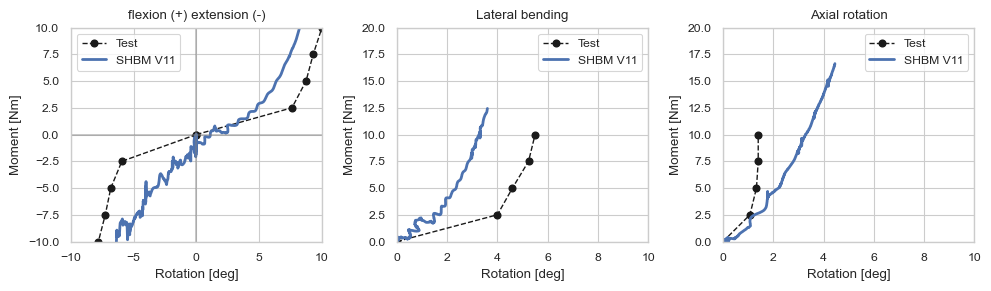

In [60]:
fig_FSU, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 3))

ax[0].plot(exp_L5S1.Fx,exp_L5S1.Fy,**pmhs_marked,label='Test')
ax[0].plot(exp_L5S1.Ex,-exp_L5S1.Ey,**pmhs_marked)
ax[0].plot(np.degrees(pd.DataFrame(sim_output['flexion'].Spine.L5y.angle
                                   -sim_output['flexion'].Spine.S1y.angle)),
           pd.DataFrame(sim_output['flexion'].loadcell.Momenty.moment),**s11,label='SHBM V11')
ax[0].plot(np.degrees(pd.DataFrame(sim_output['extension'].Spine.L5y.angle.iloc[0:600]
                                   -sim_output['extension'].Spine.S1y.angle.iloc[0:600])),
           pd.DataFrame(sim_output['extension'].loadcell.Momenty.moment.iloc[0:600]),**s11)
ax[0].set(xlim=[-10,10],ylim=[-10,10],xlabel='Rotation [deg]',title='flexion (+) extension (-)',ylabel='Moment [Nm]');
ax[0].axhline(y=0, color='gray',alpha=0.5)
ax[0].axvline(x=0, color='gray',alpha=0.5)

ax[1].plot(exp_L5S1.Lbx,exp_L5S1.Lby,**pmhs_marked,label='Test')
ax[1].plot(-np.degrees(pd.DataFrame(sim_output['lateral_bending'].Spine.L5x.angle.iloc[0:700]
                                    -sim_output['lateral_bending'].Spine.S1x.angle.iloc[0:700])),
           -pd.DataFrame(sim_output['lateral_bending'].loadcell.Momentx.moment.iloc[0:700]),**s11,label='SHBM V11')
ax[1].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Lateral bending',ylabel='Moment [Nm]');

ax[2].plot(exp_L5S1.Arx,exp_L5S1.Ary,**pmhs_marked,label='Test')
ax[2].plot(-np.degrees(pd.DataFrame(sim_output['axial_rotation'].Spine.L5z.angle
                                    -sim_output['axial_rotation'].Spine.S1z.angle)),
           -pd.DataFrame(sim_output['axial_rotation'].loadcell.Momentz.moment),**s11,label='SHBM V11')
ax[2].set(xlim=[0,10],ylim=[0,20],xlabel='Rotation [deg]',title='Axial rotation',ylabel='Moment [Nm]');

for l in range (3):
    ax[l].legend()
fig_FSU.tight_layout()

## Energy Plots

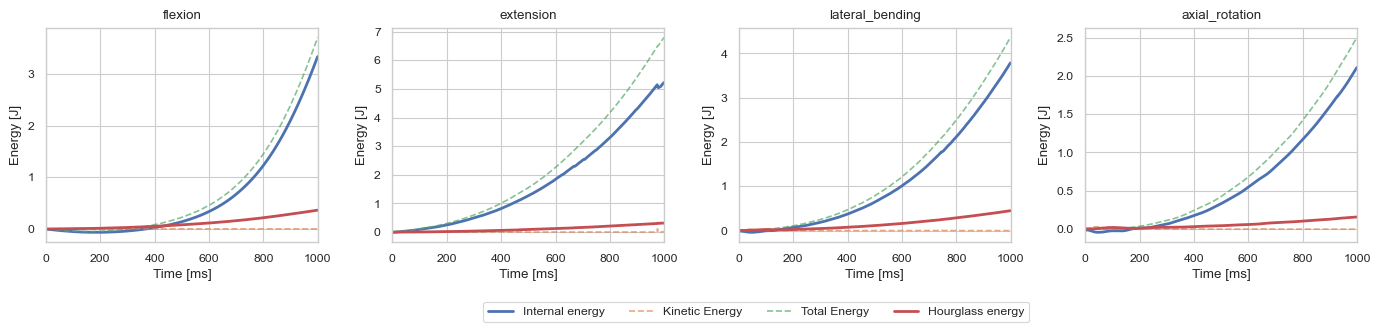

In [66]:
fig_eny, axs = plt.subplots(nrows=1, ncols=4,figsize=(14,3))
i=0
for ax in axs.flat:
    ax.plot(sim_output[Tests[i]].MODEL.Internal_Energy.time,sim_output[Tests[i]].MODEL.Internal_Energy.energy,linewidth=2)
    ax.plot(sim_output[Tests[i]].MODEL.Kinetic_Energy.time,sim_output[Tests[i]].MODEL.Kinetic_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output[Tests[i]].MODEL.Total_Energy.time,sim_output[Tests[i]].MODEL.Total_Energy.energy,linestyle='--',alpha=0.7)
    ax.plot(sim_output[Tests[i]].MODEL.Hourglass_Energy.time,sim_output[Tests[i]].MODEL.Hourglass_Energy.energy,linewidth=2)
    ax.set(title="{}".format(Tests[i]),xlabel='Time [ms]',ylabel='Energy [J]',xlim=[0,1000])
    i=i+1

fig_eny.legend(["Internal energy","Kinetic Energy","Total Energy","Hourglass energy"], bbox_to_anchor=(0.75,0),ncols=5);
fig_eny.tight_layout()